In [107]:
import torch
from dataset import BrainSegmentationDataset as Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg
from medpy.filter.binary import largest_connected_component
from matplotlib import pyplot as plt
from unet import UNet
from utils import dsc, gray2rgb, outline

# Loading the Dataset
Source: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?resource=download

In [108]:
def data_loader(path: str, img_size: int=256, batch_size: int=32):
    dataset = Dataset(
        images_dir=path,
        subset="validation",
        image_size=img_size,
        random_sampling=False,
    )
    loader = DataLoader(
        dataset, batch_size=batch_size, drop_last=False, num_workers=1
    )
    return loader

## Initializing Torch Dataloader

In [109]:
loader = data_loader("./data/kaggle_3m/") # Includes basic normalization 

reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


In [110]:
tfm = T.ToPILImage() # PyTorch stores data in tensors, convert back to image to display

In [111]:
data = next(iter(loader)) # Dataloader is always an iterable object unlike dataset

In [112]:
img = tfm(data[0][10]) # (img idx, batch idx)

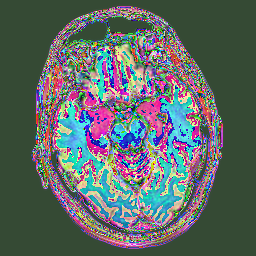

In [113]:
img # Result of transformation and normalization

# Loading the UNET Architecture

In [114]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # Init device using CPU or GPU

In [115]:
with torch.no_grad():
    unet = UNet(in_channels=Dataset.in_channels, out_channels=Dataset.out_channels)
    state_dict = torch.load("./models/unet.pt", map_location=device) # Loading trained weights
    unet.load_state_dict(state_dict)
    unet.eval()
    unet.to(device)

C:\Users\vansh\AppData\Local\Temp\ipykernel_29236\850509019.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./models/unet.pt", map_location=devi

In [116]:
x, y_true = data

In [117]:
x, y_true = x.to(device), y_true.to(device) # Map to GPU

## Making a prediction

In [118]:
y_pred = unet(x)
y_pred_np = y_pred.detach().cpu().numpy() # Parsing as np array

In [119]:
x_np = x.detach().cpu().numpy()
y_true_np = y_true.detach().cpu().numpy()

In [120]:
pred_batch = []
input_batch = []
true_batch = []

In [121]:
pred_batch.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
true_batch.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
input_batch.extend([x_np[s] for s in range(x_np.shape[0])])

# Post Processing Data

In [122]:
def postprocess_single_batch(input_batch, pred_batch, true_batch, patient_slice_index, patients):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = input_batch[index:index + num_slices[p]]
        volume_pred = np.round(pred_batch[index:index + num_slices[p]]).astype(int)
        volume_pred = largest_connected_component(volume_pred)
        volume_true = true_batch[index:index + num_slices[p]]
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

In [123]:
volumes = postprocess_single_batch(
            x_np,
            y_pred_np,
            y_true_np,
            loader.dataset.patient_slice_index[:x.shape[0]],
            loader.dataset.patients,
        )

In [132]:
volumes['TCGA_HT_7616_19940813'][2].shape

(28, 1, 256, 256)

In [134]:
batch_images = []
for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    for s in range(x.shape[0]):
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0], color=[0, 255, 0])
        batch_images.append(image)

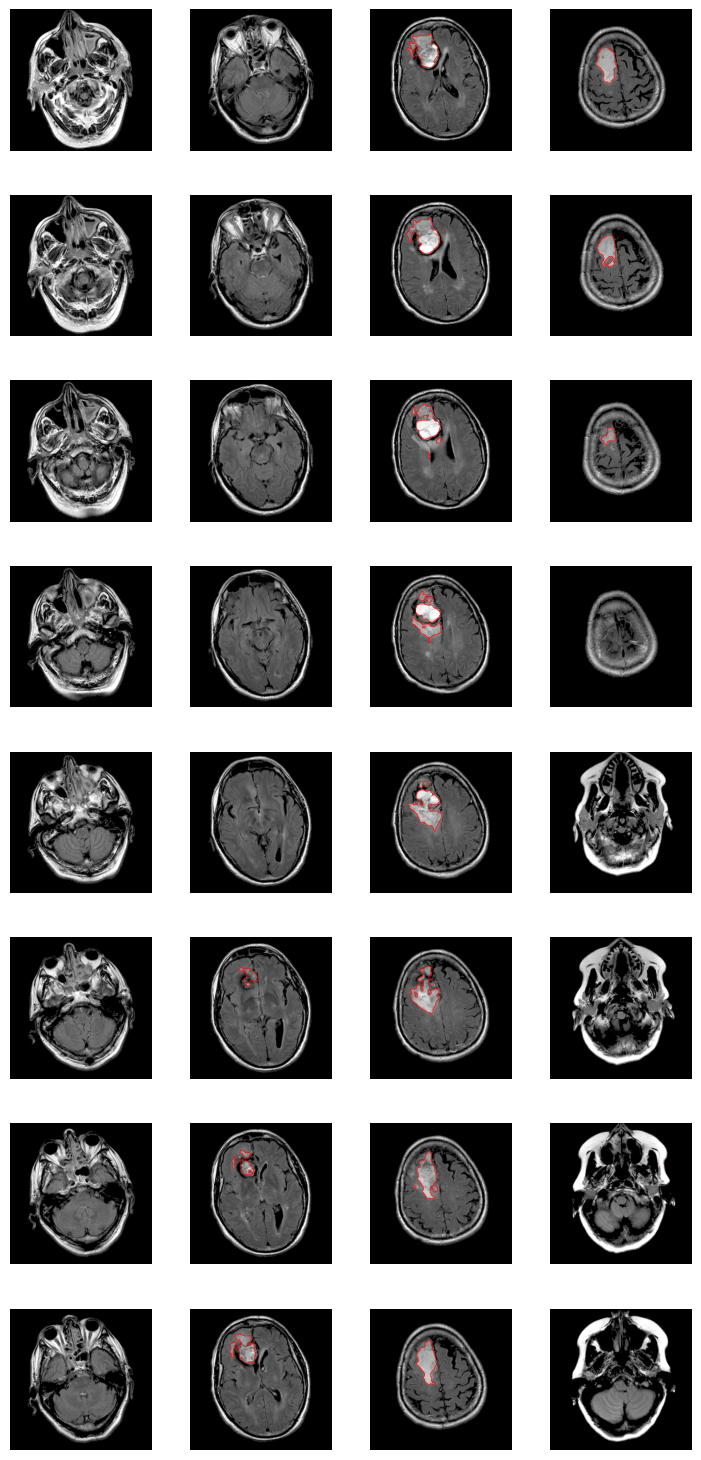

In [162]:
fig, ax = plt.subplots(8, 4)
fig.set_size_inches(20, 15)
fig.tight_layout(w_pad=-90)
for idx, img in enumerate(batch_images):
    ax[idx%8][idx//8].imshow(img)
    ax[idx%8][idx//8].axis("off")